In [152]:
import tqdm
import pandas as pd 
import wandb
import functools


@functools.cache
def get_df_from_wandb(path):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path)
    
    data_df_lines = []
    for run in tqdm.tqdm(runs): 
        data_df_lines.append({
            'Name': run.name,
            'Commit': run.commit,
            **run.summary._json_dict,
            **{k: v for k,v in run.config.items() if not k.startswith('_')},
        })
    data_df = pd.DataFrame(data_df_lines)
    return data_df

In [153]:
df = get_df_from_wandb('galqiwi/test')
df = df[['test_grid_mse', 'ppl_delta_by_layer_name']]
df = df.dropna()

df

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 25101.28it/s]


,test_grid_mse,ppl_delta_by_layer_name
0,0.007814,{'model.layers.0.mlp.down_proj': 0.02003955841...
1,0.002022,{'model.layers.0.mlp.down_proj': 0.00313472747...
2,0.002523,{'model.layers.0.mlp.down_proj': 0.00144672393...
3,0.000637,{'model.layers.0.mlp.down_proj': 0.00096416473...
6,0.000581,"{'model.layers.0.mlp.down_proj': 0, 'model.lay..."
7,0.000634,{'model.layers.0.mlp.down_proj': 0.00120544433...
8,0.015122,{'model.layers.0.mlp.down_proj': 0.04424571990...
9,0.030044,{'model.layers.0.mlp.down_proj': 0.07678890228...
10,0.025633,{'model.layers.0.mlp.down_proj': 0.07022190093...
11,0.002508,{'model.layers.0.mlp.down_proj': 0.00096416473...


In [154]:
df.to_csv('test.csv')

In [157]:
ppl_delta_lines = []

for _, row in df.iterrows():
    test_grid_mse = row['test_grid_mse']
    ppl_delta_by_layer_name = row['ppl_delta_by_layer_name']
    for layer, ppl_delta in ppl_delta_by_layer_name.items():
        ppl_delta_lines.append({
            'test_grid_mse': test_grid_mse,
            'layer': layer,
            'ppl_delta': ppl_delta,
        })

layers = sorted(set(line['layer'] for line in ppl_delta_lines))

for layer in layers:
    ppl_delta_lines.append({
        'test_grid_mse': 0.0,
        'layer': layer,
        'ppl_delta': 0.0,        
    })

ppl_delta_df = pd.DataFrame(ppl_delta_lines)
ppl_delta_df.sample(3)

,test_grid_mse,layer,ppl_delta
1440,0.009467,model.layers.7.self_attn.q_proj,0.001688
172,0.002022,model.layers.2.self_attn.o_proj,-0.000241
1079,0.002508,model.layers.4.mlp.gate_proj,0.000482


In [158]:
layers = sorted(set(ppl_delta_df['layer']))
len(layers)

112

In [159]:
import statsmodels.api as sm


def get_scale(x, y):
    model = sm.OLS(y, x).fit()
    lower, upper = model.conf_int(alpha=0.05).values[0]
    mid = (lower + upper) / 2
    err = (upper - lower) / 2
    return mid, err

In [160]:
means = []
errors = []

for layer in layers:
    to_plot = ppl_delta_df
    to_plot = to_plot[to_plot['layer'] == layer]
    mid, err = get_scale(to_plot['test_grid_mse'], to_plot['ppl_delta'])
    means.append(mid)
    errors.append(err)

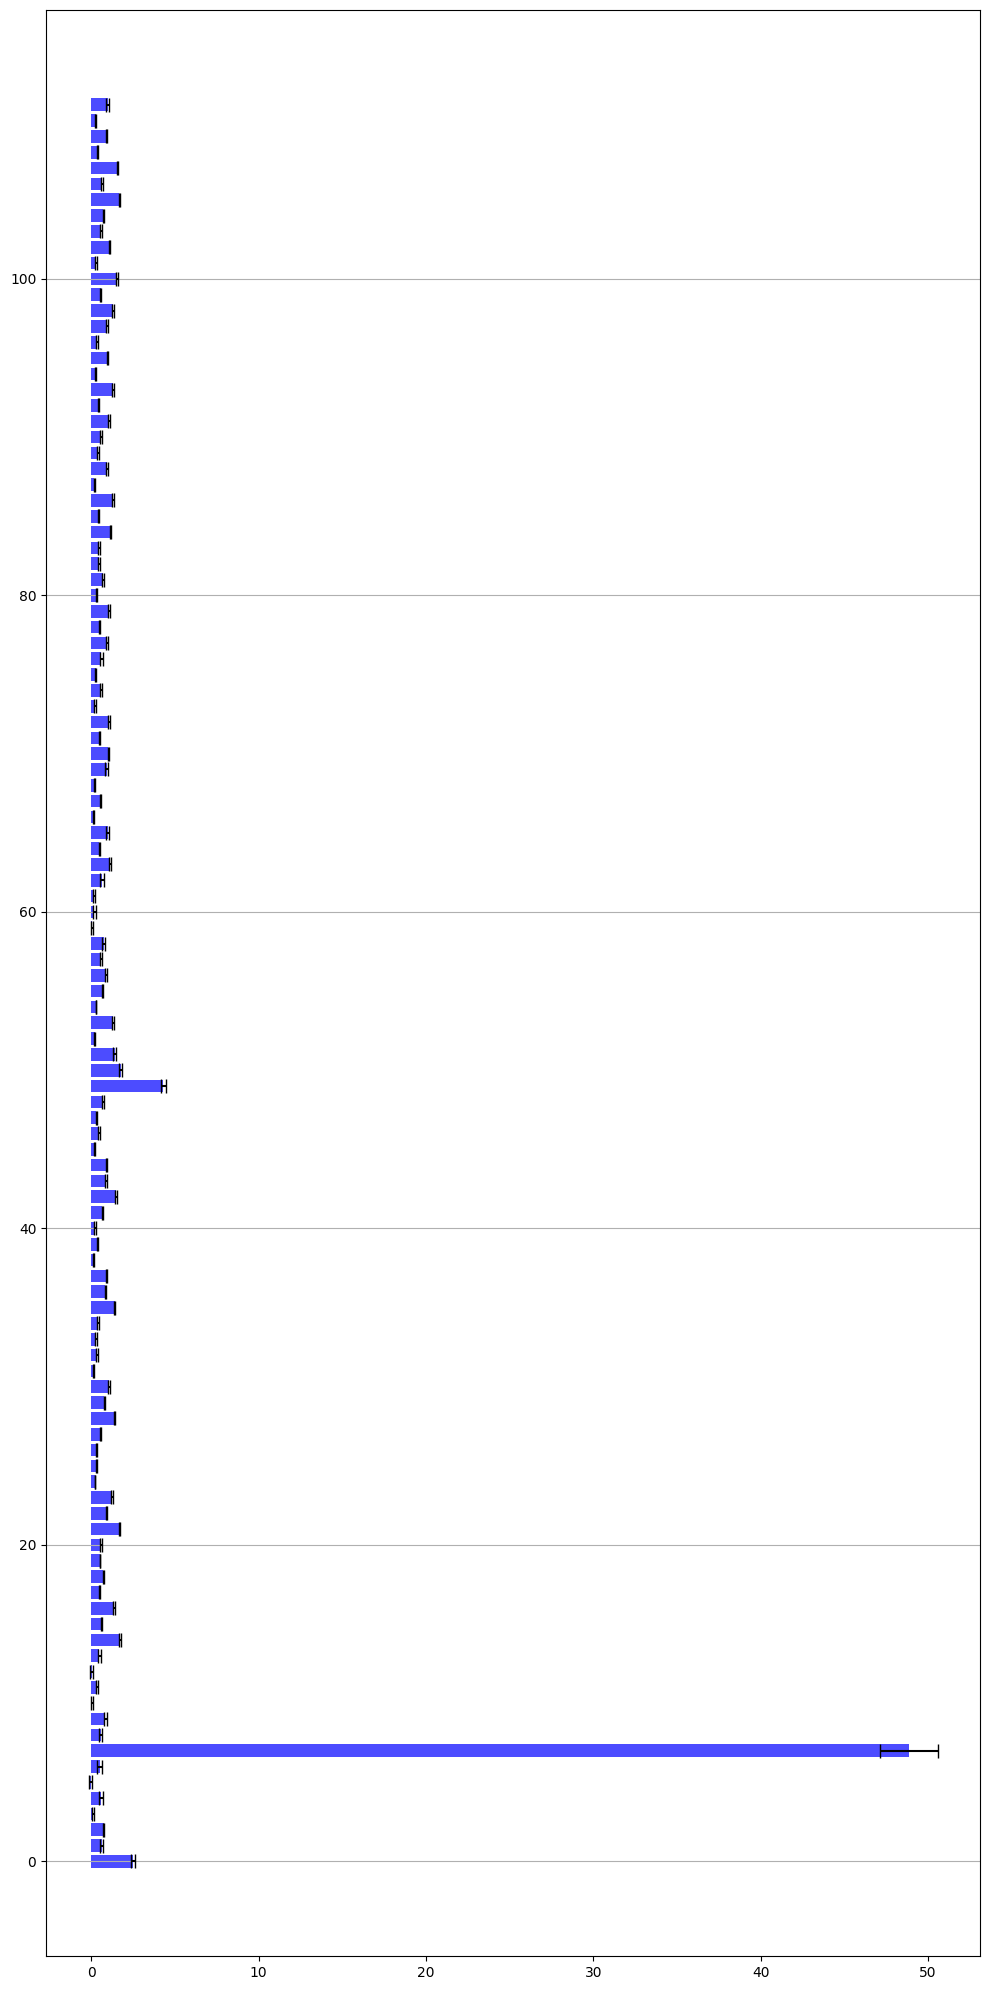

In [161]:
import numpy as np
fig, ax = plt.subplots(figsize=(10, 20))

x = np.arange(len(layers))  # x locations for the groups
ax.barh(x, means, xerr=errors, capsize=5, align='center', alpha=0.7, ecolor='black', color='blue')
ax.yaxis.grid(True)

# Save the figure or show
plt.tight_layout()
plt.show()

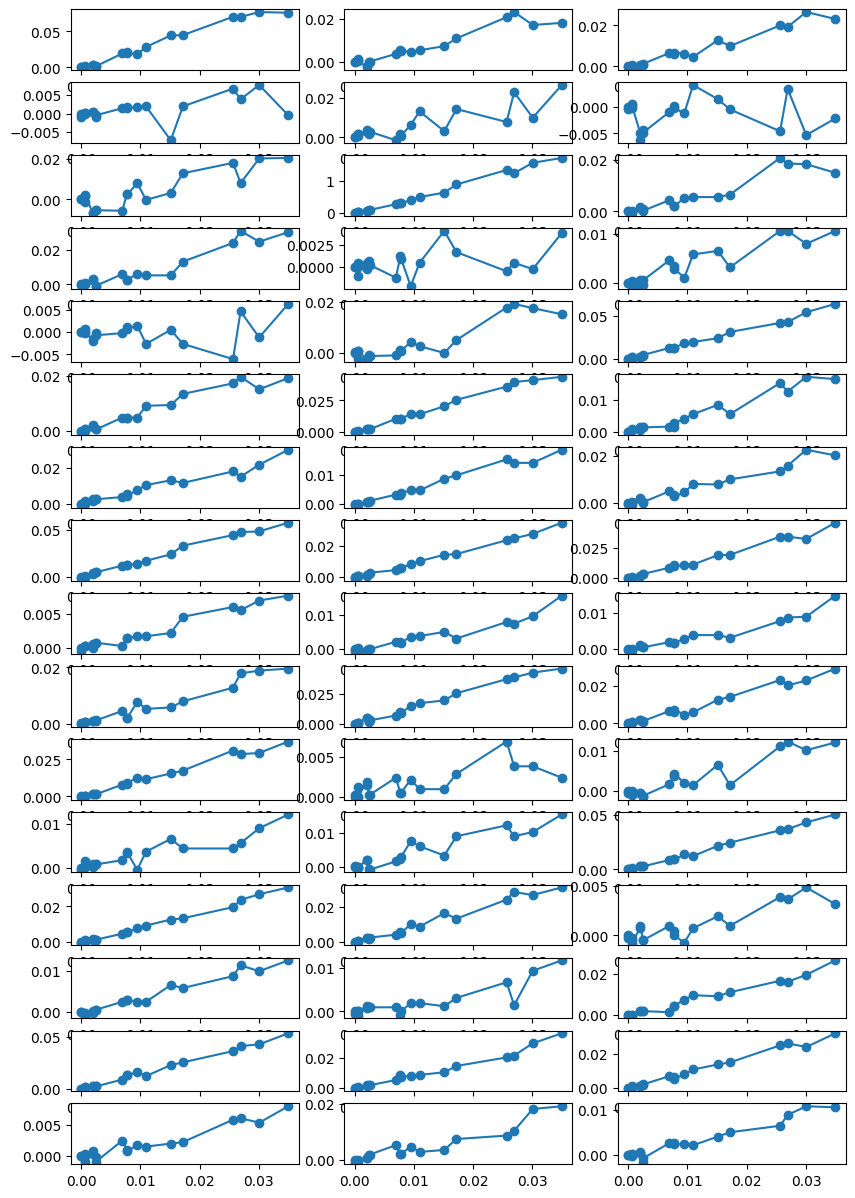

In [162]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(16, 3, figsize=(10, 15))
axes = axes.reshape(-1)

for layer, ax in zip(layers, axes):
    to_plot = ppl_delta_df
    to_plot = to_plot[to_plot['layer'] == layer]
    # to_plot = to_plot[to_plot['ppl_delta'] < 0.01]
    to_plot = to_plot.copy().sort_values('test_grid_mse')
    ax.scatter(to_plot['test_grid_mse'], to_plot['ppl_delta'])
    ax.plot(to_plot['test_grid_mse'], to_plot['ppl_delta'])

plt.show()

In [132]:
import requests
from ast import literal_eval
import pandas as pd

grids = literal_eval(requests.get(
    'https://gist.githubusercontent.com/galqiwi/64533350e3dcf4dfa31cd33d9956efb4/raw/fbec4fe8eaf81ce0b946eae5ef2137b3a8cd0916/UPDATED_GRIDS_MSE'
).text)

grids.append({
    'edenn_d': -1,
    'edenn_n': -1,
    'bits': 16,
    'mse': 0.0,
})

grids = pd.DataFrame(grids)
grids['name'] = grids.apply(
    lambda row: 'edenn_d=' + str(row['edenn_d']) + ';edenn_n=' + str(row['edenn_n']),
    axis=1,
)
grids = grids[['bits', 'mse', 'name', 'edenn_d', 'edenn_n']]
print(len(grids))
grids.sample(3)

77


,bits,mse,name,edenn_d,edenn_n
26,4.0,0.006969,edenn_d=3;edenn_n=4096,3,4096
63,0.5,0.621237,edenn_d=6;edenn_n=8,6,8
42,0.8,0.431198,edenn_d=5;edenn_n=16,5,16


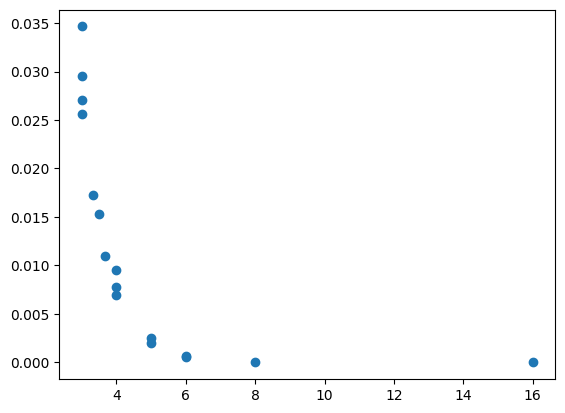

In [133]:
to_plot = grids[(grids['mse'] < 0.035)].sort_values('mse')

plt.scatter(to_plot['bits'], to_plot['mse'])

In [143]:
sorted(list(tuple(row) for _, row in to_plot[['edenn_d', 'edenn_n']].iterrows()))

[(-1, -1),
 (1, 8),
 (1, 16),
 (1, 32),
 (1, 64),
 (1, 256),
 (2, 64),
 (2, 128),
 (2, 256),
 (2, 1024),
 (2, 4096),
 (3, 512),
 (3, 1024),
 (3, 2048),
 (3, 4096),
 (4, 4096)]